# Data analisys on Covid-19 

Considering the positive cases identified are non representative for the population of real positive to COVID-19, differnt approach can be considering just the hospedalized portion of the infected population.

In order to try this approach we are using the data provided by: [github repository](git@github.com:pcm-dpc/COVID-19.git) that need to be cloned within this folder.

In [80]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as pyplot
import numpy as np
from scipy import optimize
pd.set_option('mode.chained_assignment', None)


filename = "COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv"
data = pd.read_csv(filename)
data['data'] = pd.to_datetime(data['data']).dt.normalize()

display(data.head())

%matplotlib inline

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
0,2020-02-24,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,0,5,NaN,NaN
1,2020-02-24,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2,2020-02-24,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN
3,2020-02-24,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN
4,2020-02-24,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,0,10,NaN,NaN


The precomputated field useful for this experiment are loaded within the relevant one in the new dataset:

some fields need to be adjusted in order to respect the proportion between the hospidalized and home cured:

* _guariti_ospedalizzati_ as the proportional value for _dimessi_guariti_
* _morti_ospdedalizzati_ as the proportional value for _deceduti_

In [81]:
ratio_hospitalized = (data['totale_ospedalizzati'] / data['totale_positivi']).fillna(0)
df_italy = pd.DataFrame(data['data'])
df_italy['guariti_ospedalizzati'] = data['dimessi_guariti'] * ratio_hospitalized
df_italy['morti_ospedalizzati'] = data['deceduti'] * ratio_hospitalized
valid_cases = data['totale_ospedalizzati'] + df_italy['guariti_ospedalizzati'] + df_italy['morti_ospedalizzati']
df_italy['totali_accertati'] = valid_cases
df_italy['data'] = data['data']
df_italy['denominazione_regione'] = data['denominazione_regione']
df_italy['ricoverati_con_sintomi'] = data['ricoverati_con_sintomi']
df_italy['terapia_intensiva'] = data['terapia_intensiva']
df_italy = df_italy.sort_values(by=['data'])

display(df_italy.head())

,data,guariti_ospedalizzati,morti_ospedalizzati,totali_accertati,denominazione_regione,ricoverati_con_sintomi,terapia_intensiva
0,2020-02-24,0.0,0.0,0.0,Abruzzo,0,0
20,2020-02-24,0.0,0.5,16.5,Veneto,12,4
19,2020-02-24,0.0,0.0,0.0,Valle d'Aosta,0,0
18,2020-02-24,0.0,0.0,0.0,Umbria,0,0
17,2020-02-24,0.0,0.0,0.0,P.A. Trento,0,0


in order to apply the logistic regression this are the functions needed

In [82]:
def sigmoid(p,x):
    x0,y0,c,k=p
    y = c / (1 + np.exp(-k*(x-x0))) + y0
    return y
 
def residuals(p,x,y):
    return y - sigmoid(p,x)

def vertline(x, max):
    """Draws a vertical line at x."""
    pyplot.plot([x, x], [0, max], '--' ,linewidth=2, color='0.8')
display(df_italy.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 0 to 797
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   data                    798 non-null    datetime64[ns]
 1   guariti_ospedalizzati   798 non-null    float64       
 2   morti_ospedalizzati     798 non-null    float64       
 3   totali_accertati        798 non-null    float64       
 4   denominazione_regione   798 non-null    object        
 5   ricoverati_con_sintomi  798 non-null    int64         
 6   terapia_intensiva       798 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 49.9+ KB


None

Display the trend of the logistic regression for the data related to cases that hit the hospidalization is the main objective of this work, in order to predict the trend of the infection and try to undestand if the trend is improving or not.

in the following section we well show the trend of the ligistic regression for the last 5 days.

In addition will be highlighted the area made by the sum of:

* intensive care 
* hospitalization

this will show how many peolple are 

In [104]:

def plot_region(region_name):
    final = df_italy.copy()
    if region_name == '*':
        region = final.groupby(final['data'].dt.date).sum()
    else:
        region = final[final['denominazione_regione']==region_name]
        region.drop_duplicates(subset='data',inplace=True)
    region['day'] = range(1,len(region)+1)
    x = region['day'].tolist()
    y = region['totali_accertati'].tolist() #.diff() in order to have deltas
    max = region['totali_accertati'].max()
    y[0] = 0.0
    pyplot.figure(figsize=[13.0,8.0])
    pyplot.title('Number of cases that require hospitalization')
    pyplot.xlabel('days from the beginning')
    pyplot.ylabel('number of cases')
    vertline(x[-1], max*1.5)  #today
    #pyplot.plot([x[-1], x[-1]], [0, 300], linewidth=3, color='0.8')
    pyplot.grid(b=True, color='g')
    pyplot.plot(x,y,'k-', alpha=0.5, label='real data')
    #z = np.polyfit(x, y, 3)
    #y1 = np.polyval(np.poly1d(z),x);
    #pyplot.plot(x,y1, alpha=0.3, label='polynomial regression')
    style = [('-.',0.3)]*len(x)
    style[len(x)-1] = ('*-.',0.9)
    for n in range(len(x)-7,len(x)):
        x0 = x[0:n]
        y0 = y[0:n]
        x_f = x0.copy()
        x_f.extend(range(len(x),len(x)+20))
        p, cov, infodict, mesg, ier = optimize.leastsq(residuals,[0,0,0,0],args=(x0,np.array(y0)),full_output=1)
        x1,y1,c,k=p
        pyplot.plot(x_f, c / (1 + np.exp(-k*((x_f)-x1))) + y1,style[n][0], alpha=style[n][1], label='logistic regression (day=%d)'%(n+1))

    ### down here all wrong ##### 
    pyplot.plot(x, region['terapia_intensiva'])
    pyplot.fill_between(x, region['terapia_intensiva'], alpha=0.3, hatch='\\\\\\', label='intense care')
    pyplot.plot(x, region['ricoverati_con_sintomi']+region['terapia_intensiva'])
    pyplot.fill_between(x, region['ricoverati_con_sintomi']+region['terapia_intensiva'], alpha=0.3, hatch='///', label='hosplitalized')
    pyplot.legend(loc='upper left')

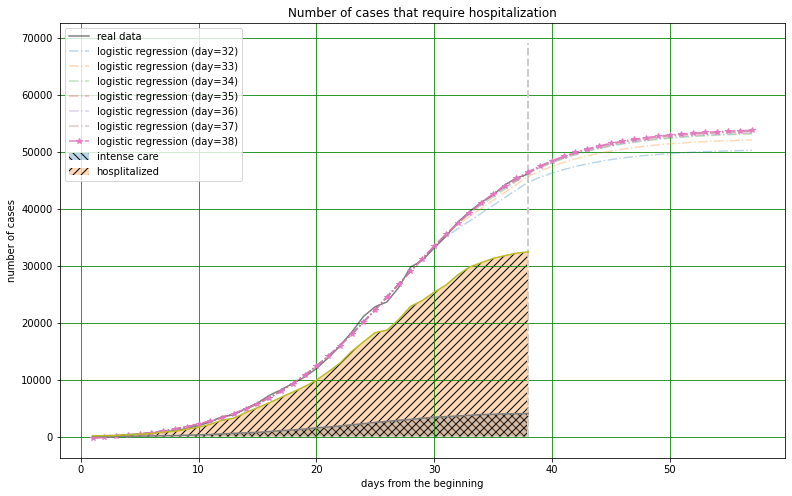

In [105]:
plot_region('*') #GLOBAL TREND FOR ITALY

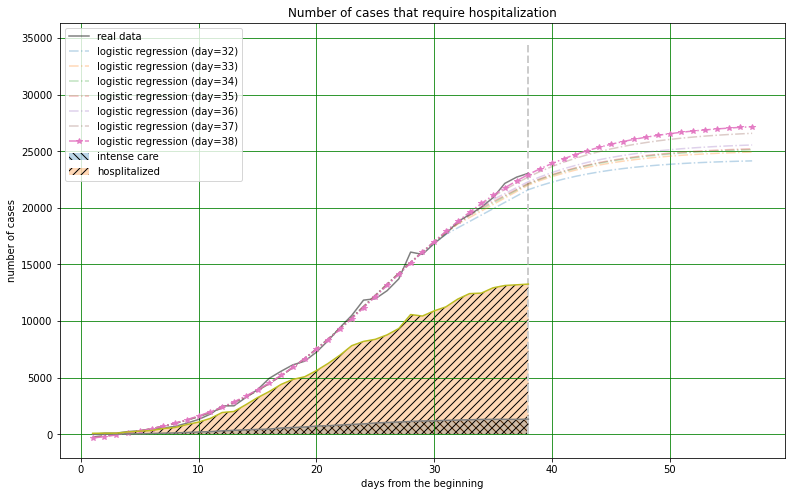

In [106]:
plot_region('Lombardia')

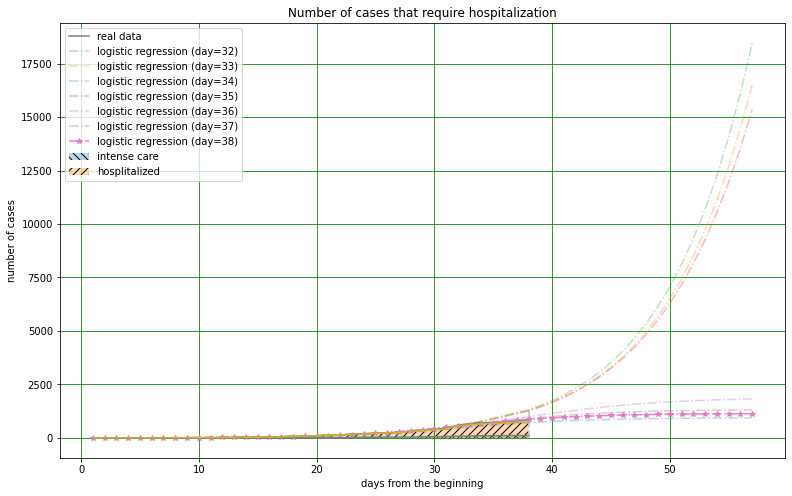

In [107]:
plot_region("Puglia")

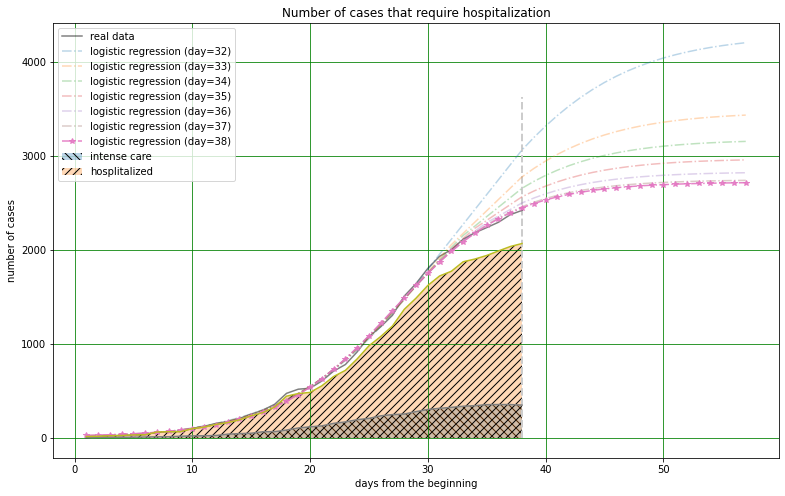

In [108]:
plot_region("Veneto")

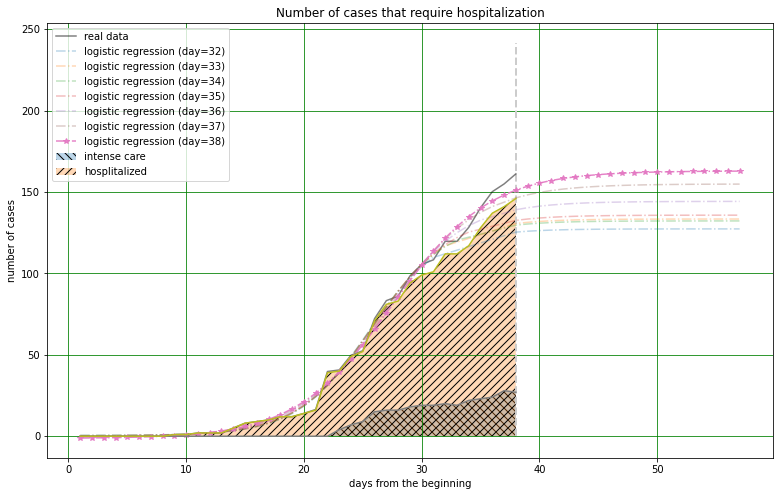

In [109]:
plot_region("Sardegna")

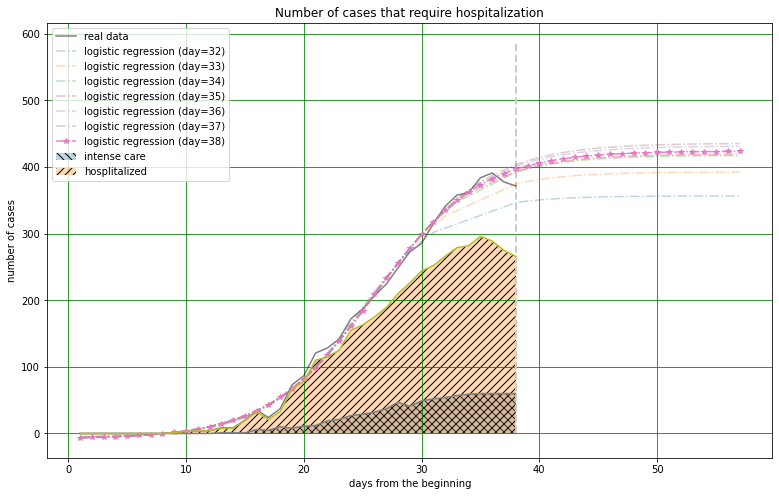

In [110]:
plot_region('Friuli Venezia Giulia')

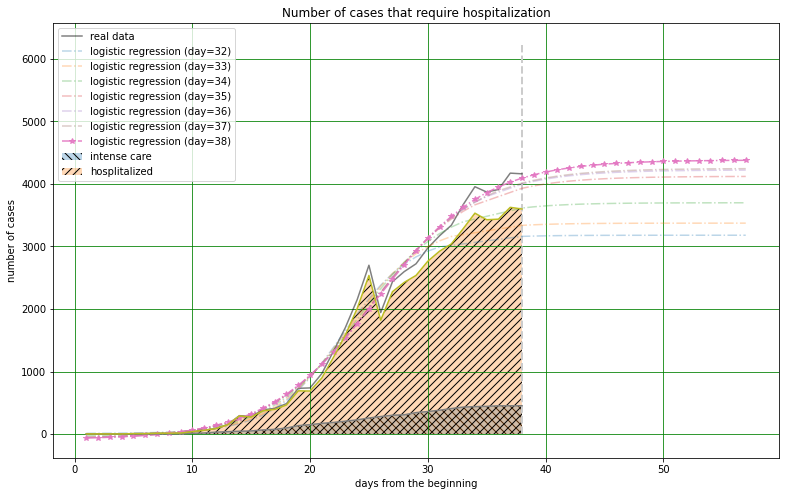

In [111]:
plot_region('Piemonte')

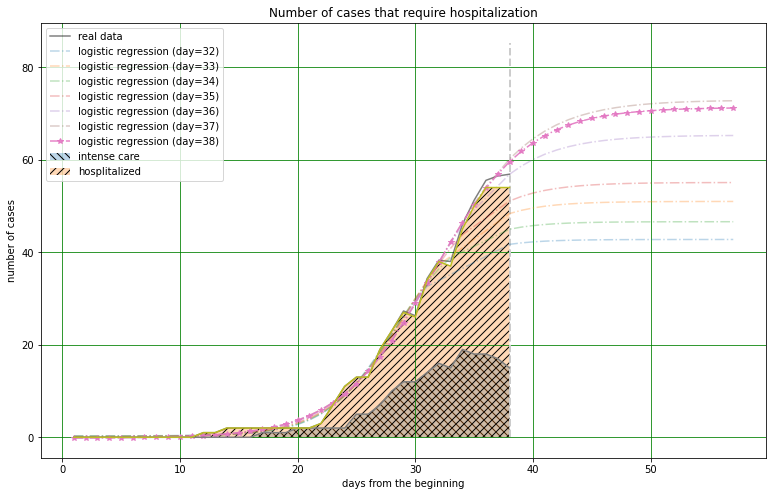

In [112]:
plot_region('Basilicata')

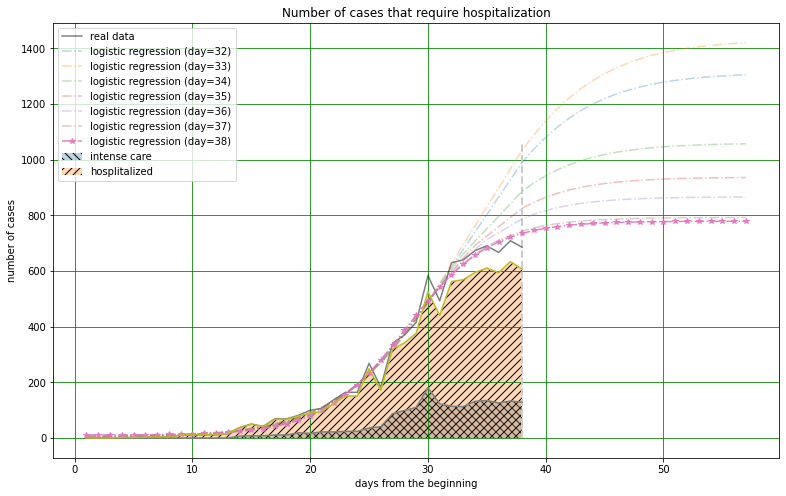

In [113]:
plot_region('Campania')

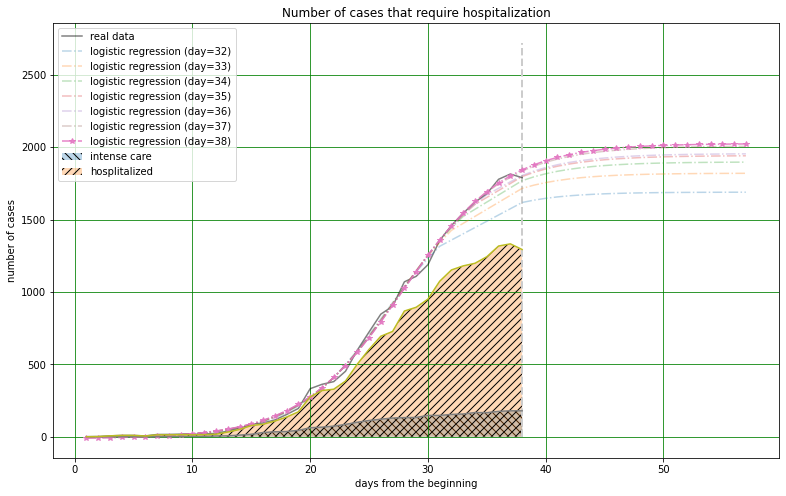

In [114]:
plot_region('Liguria')